In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering
from scipy.spatial.distance import squareform
from matplotlib.colors import to_hex
import scvi

# Import MrVI from scvi-tools external modules
from scvi.external import MRVI

/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [3]:
import os
os.environ["JAX_PLATFORM_NAME"] = "gpu"  # Set this to use GPU

import jax
print("JAX version:", jax.__version__)
print("Available JAX devices:", jax.devices())
print("JAX backend:", jax.config.x64_enabled)

# If devices show GPU, then proceed with your MRVI training

JAX version: 0.5.2
Available JAX devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
JAX backend: False


In [4]:
scvi.settings.seed = 0
adata = sc.read('a549_combined_data.h5ad')
print(f"Loaded dataset: {adata.shape[0]} cells and {adata.shape[1]} genes")

# Basic preprocessing
print("Performing basic preprocessing...")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
# Check if preprocessing has already been done
preprocessing_needed = True

if "log1p" in adata.uns:
    print("Dataset appears to be already normalized")
    preprocessing_needed = False

if preprocessing_needed:
    print("Performing basic preprocessing...")
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=10)
    print(f"After filtering: {adata.shape[0]} cells, {adata.shape[1]} genes")
    
    # Normalize the data
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    print("Normalization complete")
else:
    print("Skipping preprocessing as data appears to be already processed")

# Identify highly variable genes if needed
if "highly_variable" not in adata.var.columns:
    print("Identifying highly variable genes...")
    sc.pp.highly_variable_genes(
        adata, 
        n_top_genes=10000,
        inplace=True, 
        subset=True, 
        flavor="seurat_v3"
    )
else:
    print("Using existing highly variable genes annotation")
    # Subset to highly variable genes if not already done
    if adata.shape[1] > 10000:
        adata = adata[:, adata.var.highly_variable]
        print(f"Subsetted to {adata.shape[1]} highly variable genes")
print("Dataset dimensions:", adata.shape[0], "cells ×", adata.shape[1], "genes")
print("\nObservation metadata columns:")
for col in adata.obs.columns:
    print(f"- {col}")

print("\nVariable metadata columns:")
for col in adata.var.columns:
    print(f"- {col}")
# We can directly use the columns from your data structure
sample_key = "sample_id"  # Your sample identifier
batch_key = "batch" if "batch" in adata.obs.columns else None  # Use batch if available

# Your data already has 'is_control' and 'drug' columns which are perfect for MrVI
print(f"\nUsing '{sample_key}' as sample key and {batch_key} as batch key")

if "is_control" in adata.obs.columns:
    print("Found 'is_control' column - will use for control/treatment comparisons")
    
if "drug" in adata.obs.columns:
    print("\nDrug distribution in dataset:")
    drug_counts = adata.obs["drug"].value_counts()
    for drug, count in drug_counts.items():
        print(f"- {drug}: {count} cells ({count/adata.shape[0]*100:.1f}%)")
    
# Check preprocessing status
if "log1p" in adata.uns:
    print("\nData already normalized with log1p transformation")

# Setup anndata for MrVI with your existing columns
print("\nSetting up anndata for MrVI...")
print(f"Using '{sample_key}' as sample key")
if batch_key:
    print(f"Using '{batch_key}' as batch key")

# Make sure to include batch_key only if it's defined
if batch_key:
    MRVI.setup_anndata(adata, sample_key=sample_key, batch_key=batch_key)
else:
    MRVI.setup_anndata(adata, sample_key=sample_key)

Seed set to 0


Loaded dataset: 246262 cells and 33388 genes
Performing basic preprocessing...
Dataset appears to be already normalized
Skipping preprocessing as data appears to be already processed
Identifying highly variable genes...


/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Dataset dimensions: 246262 cells × 10000 genes

Observation metadata columns:
- gene_count
- umi_count
- SRX_accession
- sample_id
- batch
- n_genes
- perturbation
- is_control
- drug

Variable metadata columns:
- gene_symbols
- feature_types
- n_cells
- highly_variable
- highly_variable_rank
- means
- variances
- variances_norm

Using 'sample_id' as sample key and batch as batch key
Found 'is_control' column - will use for control/treatment comparisons

Drug distribution in dataset:
- acme hs dissociation: 38909 cells (15.8%)
- infected with h3n2 (a/perth/16: 25911 cells (10.5%)
- car t cell therapy, suv39h1 kn: 23949 cells (9.7%)
- control: 20617 cells (8.4%)
- irradiation: 17272 cells (7.0%)
- infected with h1n1 (a/californ: 17121 cells (7.0%)
- irradiation (ir 6h): 16167 cells (6.6%)
- 6 gy γ-ray treatment: 15126 cells (6.1%)
- irradiated a549 cells (6 gy γ-: 12216 cells (5.0%)
- in vitro culture of ipsc-rpe: 8117 cells (3.3%)
- car t cell therapy with suv39h: 7693 cells (3.1%)
- g

/lustre/scratch/users/haonan.li/miao/scRNA_COVID/scvi-tools/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [6]:
model = MRVI(adata)


In [7]:
print("\nTraining MrVI model...")
model.train(
    max_epochs=400,
    early_stopping=True,
    early_stopping_patience=20,
    plan_kwargs={"lr": 1e-3},  # Slightly higher learning rate
    accelerator="gpu",
    devices=1,  # Explicitly use 1 GPU for stability
    deterministic=True  # For reproducibility
)


Training MrVI model...
INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/haonan.li/miniconda3/envs/scvi/lib/python3.11/ ...
/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/haonan.li/miniconda3/envs/scvi/lib/python3.11/ ...
/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:639: You passed `deterministic=True` and `benchmark=True`. Note that PyTorch ignores torch.backends.cudnn.deterministic=True when torch.backends.cudnn.benchmark=Tru

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/haonan.li/miniconda3/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 223/400:  56%|█████▌    | 223/400 [1:05:05<51:39, 17.51s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.41e+3]
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 1410.642. Signaling Trainer to stop.


In [8]:
results_dir = "a549_mrvi_results2"
fig_dir = os.path.join(results_dir, "figures")
data_dir = os.path.join(results_dir, "data")
report_dir = os.path.join(results_dir, "reports")
model_dir = os.path.join(results_dir, "models")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

In [9]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(model.history["elbo_validation"].iloc[5:])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.title("MrVI Training Convergence")
plt.savefig(f"{results_dir}/mrvi_training_convergence2.png")
plt.close()


In [11]:

# Get latent representation (u) - capturing broad cell states
print("Extracting latent representations...")
u = model.get_latent_representation()
adata.obsm["u"] = u

# Compute neighbors and UMAP embedding
print("Computing neighbors and UMAP embedding...")
sc.pp.neighbors(adata, use_rep="u")
sc.tl.umap(adata, min_dist=0.3)

Extracting latent representations...


100%|██████████| 1924/1924 [00:10<00:00, 179.19it/s]


Computing neighbors and UMAP embedding...


In [13]:
adata

AnnData object with n_obs × n_vars = 246262 × 10000
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'sample_id', 'batch', 'n_genes', 'perturbation', 'is_control', 'drug', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'rank_genes_groups', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: 'u', 'X_umap'
    obsp: 'distances', 'connectivities'

In [14]:
if "X_umap" not in adata.obsm:
    compute_umap = True
    
    # We need neighbors first
    if "neighbors" not in adata.uns:
        print("Computing neighbors...")
        sc.pp.neighbors(adata, use_rep="X_pca" if "X_pca" in adata.obsm else None)
    
    print("Computing UMAP embedding...")
    sc.tl.umap(adata, min_dist=0.3)
else:
    print("Using existing UMAP embedding")
    compute_umap = False

# Determine what to use for cell grouping
if "initial_clustering" in adata.obs.columns:
    cell_type_column = "initial_clustering"
    print(f"Using existing 'initial_clustering' annotation")
elif "leiden" in adata.obs.columns:
    cell_type_column = "leiden"
    print(f"Using existing 'leiden' clustering")
elif "louvain" in adata.obs.columns:
    cell_type_column = "louvain"
    print(f"Using existing 'louvain' clustering")
else:
    # Run clustering if no cell type annotation exists
    print("No clustering found, running Leiden clustering...")
    
    # Make sure we have neighbors computed
    if "neighbors" not in adata.uns:
        sc.pp.neighbors(adata, use_rep="X_pca" if "X_pca" in adata.obsm else None)
        
    # Run Leiden clustering
    sc.tl.leiden(adata, resolution=0.5)
    cell_type_column = "leiden"
    print(f"Created new cell clusters using Leiden algorithm")
    
# Display cluster information
if cell_type_column in adata.obs.columns:
    n_clusters = adata.obs[cell_type_column].nunique()
    print(f"\nFound {n_clusters} cell clusters/types")
    cluster_counts = adata.obs[cell_type_column].value_counts()
    
    # Show top 10 clusters by size
    print("Top 10 clusters by size:")
    for i, (cluster, count) in enumerate(cluster_counts.iloc[:10].items()):
        print(f"- Cluster {cluster}: {count} cells ({count/adata.shape[0]*100:.1f}%)")

Using existing UMAP embedding
No clustering found, running Leiden clustering...


/tmp/ipykernel_3851530/2645401136.py:34: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


Created new cell clusters using Leiden algorithm

Found 14 cell clusters/types
Top 10 clusters by size:
- Cluster 0: 34238 cells (13.9%)
- Cluster 1: 33559 cells (13.6%)
- Cluster 2: 32059 cells (13.0%)
- Cluster 3: 31672 cells (12.9%)
- Cluster 4: 30918 cells (12.6%)
- Cluster 5: 30174 cells (12.3%)
- Cluster 6: 18197 cells (7.4%)
- Cluster 7: 16366 cells (6.6%)
- Cluster 8: 7606 cells (3.1%)
- Cluster 9: 6688 cells (2.7%)


Creating UMAP visualizations...


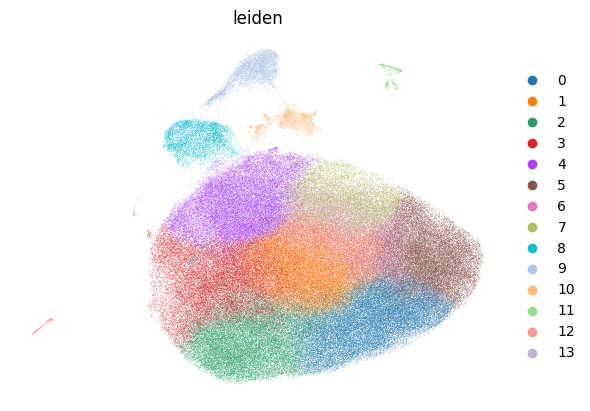

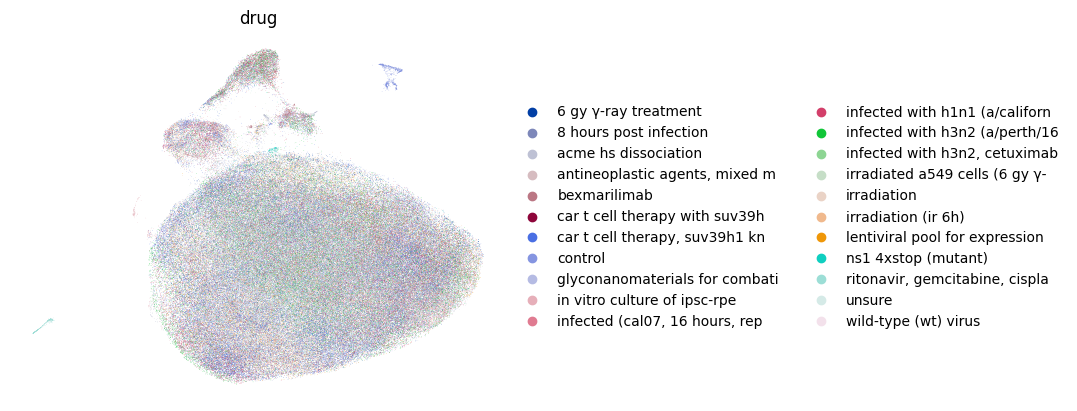

Created UMAP comparison plots for top drugs


In [17]:
print("Creating UMAP visualizations...")
def sanitize_filename(name):
    # Replace invalid characters with underscores
    invalid_chars = '<>:"/\\|?*(),'
    sanitized = ''.join('_' if c in invalid_chars else c for c in name)
    # Replace spaces with underscores and remove multiple consecutive underscores
    sanitized = '_'.join(filter(None, sanitized.split()))
    return sanitized.strip('_')
    

# Plot clusters
sc.pl.umap(
    adata,
    color=[cell_type_column],
    frameon=False,
    save=f"_cell_types.png" 
)

# Plot drug conditions - create a separate plot for each drug
if "drug" in adata.obs.columns:
    # Get unique drugs, excluding control
    drugs = [d for d in adata.obs["drug"].unique() if d != "control"]
    
    # First plot the overall drug distribution
    sc.pl.umap(
        adata,
        color=["drug"],
        frameon=False,
        save=f"_all_drugs.png"     
        )
    
    # Then create a custom plot to compare each drug vs control
    for drug in drugs:#[:10]:  
        plt.figure(figsize=(12, 5))
        
        # Subset data
        drug_mask = adata.obs["drug"] == drug
        control_mask = adata.obs["drug"] == "control"
        
        # Plot control cells
        plt.subplot(1, 2, 1)
        plt.scatter(
            adata.obsm["X_umap"][~drug_mask & ~control_mask, 0],
            adata.obsm["X_umap"][~drug_mask & ~control_mask, 1],
            c="lightgray", s=5, alpha=0.5, label="Other"
        )
        plt.scatter(
            adata.obsm["X_umap"][control_mask, 0],
            adata.obsm["X_umap"][control_mask, 1],
            c="blue", s=10, alpha=0.7, label="Control"
        )
        plt.title("Control Cells")
        plt.legend()
        plt.axis("off")
        
        # Plot drug cells
        plt.subplot(1, 2, 2)
        plt.scatter(
            adata.obsm["X_umap"][~drug_mask & ~control_mask, 0],
            adata.obsm["X_umap"][~drug_mask & ~control_mask, 1],
            c="lightgray", s=5, alpha=0.5, label="Other"
        )
        plt.scatter(
            adata.obsm["X_umap"][drug_mask, 0],
            adata.obsm["X_umap"][drug_mask, 1],
            c="red", s=10, alpha=0.7, label=drug
        )
        plt.title(f"{drug} Cells")
        plt.legend()
        plt.axis("off")
        
        plt.tight_layout()
        safe_filename = sanitize_filename(drug)
        plt.savefig(f"{fig_dir}/umap_control_vs_{safe_filename}.png")
        plt.close()
    
    print(f"Created UMAP comparison plots for top drugs")



In [16]:
# Sample distances
print("Computing sample distances...")
dists = model.get_local_sample_distances(
    keep_cell=False, 
    groupby=cell_type_column,  # Group by cell types
    batch_size=32
)

Computing sample distances...


100%|██████████| 7696/7696 [20:04<00:00,  6.39it/s]


In [59]:
print("Dimensions of dists object:", dists.dims)
print("Available coordinates:")
for dim_name in dists.dims:
    print(f"- {dim_name}: {list(dists[dim_name].values)[:5]}...")

# Attempt to extract sample distances using the correct dimensions
example_cell_type = "0"  # Your chosen cluster
print(f"Checking if '{example_cell_type}' exists in leiden_name dimension")
d1 = dists.sel(leiden_name=example_cell_type)
print(f"Successfully selected distances for leiden_name={example_cell_type}")
d1_df = d1.to_dataframe()
# Convert to dataframe correctly
d1_df = d1_df.reset_index()  # Reset the MultiIndex to columns
d1_df = d1_df.pivot(index='sample_x', columns='sample_y', values='leiden')  # Use 'leiden' as the values column

# Create dendrograms for hierarchical clustering
ds = squareform(d1_df.values)
Z = linkage(ds, method="ward")
Z = optimal_leaf_ordering(Z, ds)



Dimensions of dists object: FrozenMappingWarningOnValuesAccess({'sample_x': 33, 'sample_y': 33, 'leiden_name': 14})
Available coordinates:
- sample_x: ['ERX8792190', 'SRX17150747', 'SRX17150748', 'SRX17150749', 'SRX17150750']...
- sample_y: ['ERX8792190', 'SRX17150747', 'SRX17150748', 'SRX17150749', 'SRX17150750']...
- leiden_name: [np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4')]...
Checking if '0' exists in leiden_name dimension
Successfully selected distances for leiden_name=0


In [61]:
# Function to get sample colors (modify according to your metadata)
def get_sample_colors(d1_df):
    """Generate color mappings for A549 drug treatments"""
    # Get unique drugs/treatments from adata
    unique_drugs = adata.obs["drug"].unique()
    
    # Generate a color palette based on the number of unique drugs
    n_drugs = len(unique_drugs)
    drug_palette = sns.color_palette("tab20", n_colors=min(20, n_drugs))
    drug_map = {drug: drug_palette[i % 20] for i, drug in enumerate(unique_drugs)}
    
    # Set control to gray if it exists
    if "control" in drug_map:
        drug_map["control"] = (0.5, 0.5, 0.5)
    
    # Create a DataFrame with sample_id as index and colors
    sample_colors = pd.DataFrame(index=d1_df.index)  # Use the same index as your distance matrix
    
    # Map the drugs to their corresponding samples
    # First reset the MultiIndex to get sample_id column
    d1_df_reset = d1_df.reset_index()
    sample_ids = d1_df_reset['sample_x'].unique()
    
    # Create mapping from sample_id to drug
    sample_drug_map = adata.obs.set_index('sample_id')['drug'].to_dict()  # Convert Series to dict
    
    # Create color mapping for each sample ID
    color_dict = {}
    for sample_id in sample_ids:
        if sample_id in sample_drug_map:
            drug = sample_drug_map[sample_id]
            color_dict[sample_id] = drug_map[drug]
            
    # Convert to DataFrame
    sample_colors['drug'] = pd.Series(color_dict)
    
    return sample_colors

colors = get_sample_colors(d1_df)

# Function to perform hierarchical clustering
def get_dendrogram(dists):
    ds = squareform(dists)
    Z = linkage(ds, method="ward")
    Z = optimal_leaf_ordering(Z, ds)
    return Z


In [71]:
if 'sample_info' in dir(model) and hasattr(model.sample_info, 'drug'):
    colors = pd.DataFrame({
        'drug': pd.Series(
            ['#1f77b4' if x == 'control' else '#ff7f0e' for x in model.sample_info.drug], 
            index=model.sample_info.index
        )
    })

# Plot heatmap
plt.figure(figsize=(12, 10))
if colors is not None:
    sns.clustermap(
        d1_df,
        row_linkage=Z,
        col_linkage=Z,
        xticklabels=True,
        yticklabels=True,
        row_colors=colors,
        cmap="viridis"
    )
else:
    sns.clustermap(
        d1_df,
        row_linkage=Z,
        col_linkage=Z,
        xticklabels=True,
        yticklabels=True,
        cmap="viridis"
    )
plt.title(f"Sample Distances in {example_cell_type} Cells")
plt.savefig(f"{fig_dir}/sample_distances_{example_cell_type}.png")
plt.close()
print(f"Successfully created distance heatmap for cluster {example_cell_type}")
print("\nPerforming differential expression analysis...")
def sanitize_string(s):
    """Convert any string to a safe format for column names"""
    if not isinstance(s, str):
        return str(s)
    # Replace problematic characters
    s = s.replace(' ', '_').replace('(', '').replace(')', '')
    s = s.replace(',', '').replace('/', '_').replace('-', '_')
    s = s.replace('.', '_').replace(':', '').replace(';', '')
    # Limit length
    if len(s) > 30:
        s = s[:30]
    return s

# Since your data has 'is_control' and 'drug' columns, we'll use them
# Get all drugs and their counts
all_drugs = list(adata.obs["drug"].unique())
drug_counts = adata.obs["drug"].value_counts()
print(f"Found {len(all_drugs)} unique drugs")

for i, (drug, count) in enumerate(drug_counts.items()):
    print(f"  {i+1}. {drug}: {count} cells")

# top_drugs = drug_counts.head(5).index.tolist()
top_drugs = drug_counts.index.tolist()

if "control" in all_drugs and "control" not in top_drugs:
    top_drugs.append("control")
control_group = "control"

Successfully created distance heatmap for cluster 0

Performing differential expression analysis...
Found 22 unique drugs
  1. acme hs dissociation: 38909 cells
  2. infected with h3n2 (a/perth/16: 25911 cells
  3. car t cell therapy, suv39h1 kn: 23949 cells
  4. control: 20617 cells
  5. irradiation: 17272 cells
  6. infected with h1n1 (a/californ: 17121 cells
  7. irradiation (ir 6h): 16167 cells
  8. 6 gy γ-ray treatment: 15126 cells
  9. irradiated a549 cells (6 gy γ-: 12216 cells
  10. in vitro culture of ipsc-rpe: 8117 cells
  11. car t cell therapy with suv39h: 7693 cells
  12. glyconanomaterials for combati: 6532 cells
  13. lentiviral pool for expression: 5727 cells
  14. bexmarilimab: 5529 cells
  15. infected (cal07, 16 hours, rep: 4858 cells
  16. infected with h3n2, cetuximab : 4707 cells
  17. 8 hours post infection: 4361 cells
  18. antineoplastic agents, mixed m: 3629 cells
  19. wild-type (wt) virus: 2803 cells
  20. ns1 4xstop (mutant): 2663 cells
  21. unsure: 1259 c

<Figure size 1200x1000 with 0 Axes>

In [97]:
adata

AnnData object with n_obs × n_vars = 246262 × 10000
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'sample_id', 'batch', 'n_genes', 'perturbation', 'is_control', 'drug', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels', 'leiden', 'acme_hs_dissociation_vs_control', 'condition'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'rank_genes_groups', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'drug_colors'
    obsm: 'u', 'X_umap'
    obsp: 'distances', 'connectivities'

In [96]:
# Perform DE analysis
de_results = {}

# Get all unique drugs except control
drugs = [d for d in adata.obs['drug'].unique() if d != 'control']
print(f"Found {len(drugs)} drugs to analyze vs control")

for drug in drugs:
    print(f"\nAnalyzing differential expression for {drug} vs control...")
    
    # Create binary condition for this drug vs control
    condition_name = "drug_condition"
    mask = adata.obs['drug'].isin([drug, 'control'])
    temp_adata = adata[mask].copy()
    
    # Set up the condition column
    temp_adata.obs[condition_name] = 'control'
    temp_adata.obs.loc[temp_adata.obs['drug'] == drug, condition_name] = 'treatment'
    
    # Count cells
    drug_cells = sum(temp_adata.obs['drug'] == drug)
    control_cells = sum(temp_adata.obs['drug'] == 'control')
    print(f"  Comparing {drug_cells} {drug} cells vs {control_cells} control cells")
    
    # Run DE with appropriate parameters
    de_res = model.differential_expression(
        adata=temp_adata,
        sample_cov_keys=[condition_name],
        batch_size=128,
        use_vmap='auto',
        normalize_design_matrix=True,
        mc_samples=100,
        store_lfc=True,
        eps_lfc=0.0001,
        delta=0.3  # For computing posterior DE probabilities
    )
    
    # Store result
    de_results[drug] = de_res
    
    # Get the covariate name
    covariate_name = f"{condition_name}_treatment"
    
    # Extract and store results
    effect_size_name = f"{sanitize_string(drug)}_effect_size"
    adata.obs[effect_size_name] = np.nan  # Initialize with NaN
    adata.obs.loc[mask, effect_size_name] = de_res.effect_size.sel(covariate=covariate_name).values
    
    # Print summary statistics
    n_sig = sum(de_res.pval.sel(covariate=covariate_name).values < 0.05)
    print(f"  Found {n_sig} significantly affected genes (p < 0.05)")
    
    # Print top genes
    avg_lfc = de_res.sel(covariate=covariate_name).lfc.mean(dim="cell_name").to_pandas()
    top_genes = avg_lfc.abs().nlargest(5)
    print("\n  Top 5 genes by absolute log fold change:")
    for gene, lfc in top_genes.items():
        print(f"    {gene}: {lfc:.3f}")

print("\nDifferential expression analysis complete!")

# Save results
print("\nSaving results...")
for drug, de_res in de_results.items():
    output_file = os.path.join(data_dir, f"de_results_{sanitize_string(drug)}.h5ad")
    de_res.to_netcdf(output_file)
    print(f"Saved results for {drug} to {output_file}")

Found 21 drugs to analyze vs control

Analyzing differential expression for wild-type (wt) virus vs control...
  Comparing 2803 wild-type (wt) virus cells vs 20617 control cells
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/lustre/scratch/users/haonan.li/miao/scRNA_COVID/scvi-tools/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
  0%|          | 0/1 [00:00<?, ?it/s]

KeyError: 'drug_condition'


Visualizing results on UMAP...


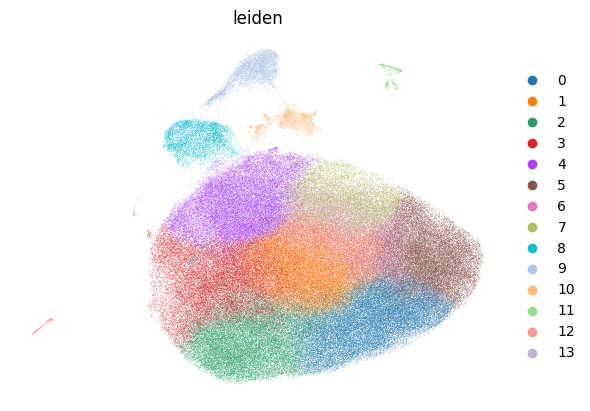

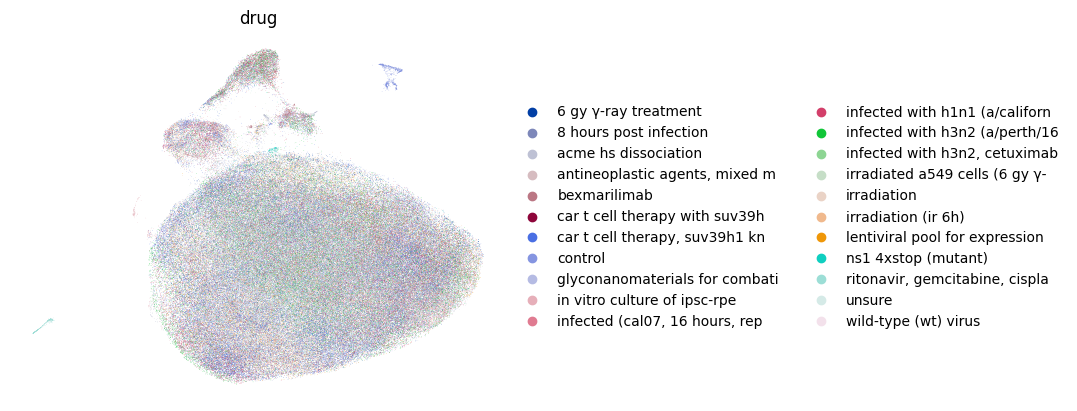


Performing differential abundance analysis...
Running differential abundance for acme hs dissociation vs control...


  3%|▎         | 1/33 [00:21<11:22, 21.32s/it]


KeyboardInterrupt: 

In [98]:




# Visualize results on UMAP
print("\nVisualizing results on UMAP...")

# Plot UMAP with key metrics
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
    save="_leiden.png"
)

# Plot drug distribution
if "drug" in adata.obs.columns:
    sc.pl.umap(
        adata,
        color=["drug"],
        frameon=False,
        save="_drug.png"
    )

# Plot overall drug effect if available
if "overall_drug_effect" in adata.obs.columns:
    sc.pl.umap(
        adata,
        color=["overall_drug_effect"],
        frameon=False,
        vmax=np.quantile(adata.obs["overall_drug_effect"], 0.95),
        cmap="viridis",
        save="_overall_drug_effect.png"
    )

# Plot individual drug effects
effect_columns = [col for col in adata.obs.columns if col.endswith("_effect_size")]
if effect_columns:
    # Plot up to 9 at a time
    for i in range(0, len(effect_columns), 9):
        batch = effect_columns[i:i+9]
        sc.pl.umap(
            adata,
            color=batch,
            frameon=False,
            ncols=3,
            vmax=0.5,  # Set a consistent scale
            cmap="viridis",
            save=f"_drug_effects_{i}.png"
        )

# Differential abundance analysis
print("\nPerforming differential abundance analysis...")

# Use drug as the covariate
    # Create a simplified version of the drug column for DA analysis
    # This avoids issues with complex category names
for drug in top_drugs:
    if drug == control_group:
        continue
        
    # Create a binary comparison column
    safe_drug = sanitize_string(drug)
    comparison_name = f"da_{safe_drug}_control"
    
    adata.obs[comparison_name] = "control"
    adata.obs.loc[adata.obs["drug"] == drug, comparison_name] = safe_drug
    
    # Make it categorical
    adata.obs[comparison_name] = pd.Categorical(
        adata.obs[comparison_name],
        categories=["control", safe_drug]
    )
    
    print(f"Running differential abundance for {drug} vs control...")
    
    da_res = model.differential_abundance(sample_cov_keys=[comparison_name])
    
    # Extract results
    drug_log_probs = da_res[f"{comparison_name}_log_probs"].loc[{f"{comparison_name}": safe_drug}]
    control_log_probs = da_res[f"{comparison_name}_log_probs"].loc[{f"{comparison_name}": "control"}]
    
    # Calculate log fold change
    log_prob_ratio = drug_log_probs - control_log_probs
    
    # Add to adata
    adata.obs[f"DA_{safe_drug}"] = log_prob_ratio.values
    
    # Visualize
    sc.pl.umap(
        adata,
        color=["leiden", f"DA_{safe_drug}"],
        frameon=False,
        ncols=1,
        vmin=-1,
        vmax=1,
        cmap="coolwarm",
        save=f"_da_{safe_drug}.png"
    )
    
    print(f"  Successfully computed differential abundance for {drug}")
    
    # Clean up
    del adata.obs[comparison_name]

print("\nAnalysis complete!")

In [ ]:

model_file = os.path.join(model_dir, "mrvi_model2")
model.save(model_file)

In [16]:
# Save results
print("Saving results...")
adata.write("mrvi_analyzed_data.h5ad")
# Create a directory structure for results
os.makedirs(results_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

# Create comprehensive visualizations
print("\nGenerating visualizations...")

# 1. Basic UMAP visualization
if "X_umap" in adata.obsm:
    # Plot clusters
    sc.pl.umap(
        adata,
        color=[cell_type_column],
        frameon=False,
        save=f"_{cell_type_column}.png",
        show=False
    )
    
    # Plot drug if available
    if "drug" in adata.obs.columns:
        sc.pl.umap(
            adata,
            color=["drug"],
            frameon=False,
            save="_drug.png",
            show=False
        )
    
    # Plot condition if available
    if "is_control" in adata.obs.columns:
        sc.pl.umap(
            adata,
            color=["is_control"],
            frameon=False,
            save="_is_control.png",
            show=False
        )
    
    # Plot perturbation if available
    if "perturbation" in adata.obs.columns:
        sc.pl.umap(
            adata,
            color=["perturbation"],
            frameon=False,
            save="_perturbation.png",
            show=False
        )
    
    # Plot overall drug effect if available
    if "overall_drug_effect" in adata.obs.columns:
        sc.pl.umap(
            adata,
            color=["overall_drug_effect"],
            frameon=False,
            vmax=np.quantile(adata.obs["overall_drug_effect"], 0.95),
            cmap="viridis",
            save="_overall_drug_effect.png",
            show=False
        )
    
    # Plot individual drug effects
    effect_columns = [col for col in adata.obs.columns if col.endswith("_effect_size")]
    if effect_columns:
        sc.pl.umap(
            adata,
            color=effect_columns[:min(9, len(effect_columns))],  # Up to 9 drugs
            frameon=False,
            ncols=3,
            vmax=0.5,  # Set a consistent scale
            cmap="viridis",
            save="_drug_effects.png",
            show=False
        )
    
    # Move figures to the results directory
    try:
        from glob import glob
        import shutil
        
        # Find all generated figures
        figures = glob("figures/*.png")
        for fig in figures:
            # Copy to our results directory
            shutil.copy(fig, fig_dir)
            
        print(f"Saved UMAP visualizations to {fig_dir}")
    except Exception as e:
        print(f"Error copying figures: {e}")
else:
    print("No UMAP embedding found, skipping UMAP visualizations")



Saving results...

Setting up results directories...

Generating visualizations...
Saved UMAP visualizations to a549_mrvi_results/figures


In [24]:
# 2. Generate a summary report
print("\nCreating analysis summary report...")

with open(os.path.join(report_dir, "analysis_summary.md"), "w") as f:
    f.write("# MrVI Analysis Summary for A549 Dataset\n\n")
    
    # Dataset information
    f.write("## Dataset Information\n\n")
    f.write(f"- Total cells: {adata.shape[0]:,}\n")
    f.write(f"- Total genes: {adata.shape[1]:,}\n")
    
    # Drug information
    if "drug" in adata.obs.columns:
        f.write("\n## Drug Distribution\n\n")
        drug_counts = adata.obs["drug"].value_counts()
        f.write("| Drug | Cell Count | Percentage |\n")
        f.write("|------|------------|------------|\n")
        for drug, count in drug_counts.items():
            f.write(f"| {drug} | {count:,} | {count/adata.shape[0]*100:.1f}% |\n")
    
    # Cluster information
    if cell_type_column in adata.obs.columns:
        f.write(f"\n## Cell Clusters ({cell_type_column})\n\n")
        cluster_counts = adata.obs[cell_type_column].value_counts()
        f.write("| Cluster | Cell Count | Percentage |\n")
        f.write("|---------|------------|------------|\n")
        for cluster, count in cluster_counts.items():
            f.write(f"| {cluster} | {count:,} | {count/adata.shape[0]*100:.1f}% |\n")
    
    # Model information
    f.write("\n## MrVI Model Information\n\n")
    f.write(f"- Sample key: {sample_key}\n")
    if batch_key:
        f.write(f"- Batch key: {batch_key}\n")
    
    # Safely access model information - check if 'mrvi' key exists
    try:
        if 'mrvi' in model.adata.uns:
            f.write(f"- Latent dimension: {model.adata.uns['mrvi']['latent_dim']}\n")
        else:
            # Alternative ways to get latent dimension
            if hasattr(model, 'module') and hasattr(model.module, 'n_latent'):
                f.write(f"- Latent dimension: {model.module.n_latent}\n")
            elif 'u' in locals() and isinstance(u, np.ndarray):
                f.write(f"- Latent dimension: {u.shape[1]}\n")
            else:
                f.write(f"- Latent dimension: Not available\n")
    except Exception as e:
        print(f"Warning: Could not retrieve latent dimension: {e}")
        f.write(f"- Latent dimension: Not available\n")
    
    # Differential Expression information
    if 'de_results' in locals():
        f.write("\n## Differential Expression Summary\n\n")
        f.write("| Drug | Significant Genes (p<0.05) | Top Genes |\n")
        f.write("|------|----------------------------|----------|\n")
        
        for drug, de_res in de_results.items():
            covariate_name = f"{drug}_vs_control_{drug}"
            if covariate_name in de_res.covariate.values:
                # Count significant genes
                sig_count = sum(de_res.pval.sel(covariate=covariate_name).values < 0.05)
                
                # Get top 5 genes by absolute LFC
                avg_lfc = de_res.sel(covariate=covariate_name).mean(dim="cell_name").lfc.to_pandas()
                top_genes = avg_lfc.abs().nlargest(5).index.tolist()
                
                f.write(f"| {drug} | {sig_count:,} | {', '.join(top_genes)} |\n")



Creating analysis summary report...


In [25]:


# 3. Save analysis results
print("\nSaving analysis results...")

# 3.1 Save latent representation
if 'u' in locals():
    latent_df = pd.DataFrame(u, index=adata.obs_names, 
                           columns=[f"dim_{i}" for i in range(u.shape[1])])
    latent_df.to_csv(os.path.join(data_dir, "mrvi_latent_representation.csv"))
    print(f"Saved latent representation to {data_dir}/mrvi_latent_representation.csv")

# 3.2 Save UMAP coordinates
if 'X_umap' in adata.obsm:
    umap_df = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names, 
                         columns=['UMAP1', 'UMAP2'])
    umap_df.to_csv(os.path.join(data_dir, "umap_coordinates.csv"))
    print(f"Saved UMAP coordinates to {data_dir}/umap_coordinates.csv")

# 3.3 Save annotated dataset with results
adata.write(os.path.join(results_dir, "a549_mrvi_analysis.h5ad"))
print(f"Saved annotated dataset to {results_dir}/a549_mrvi_analysis.h5ad")


Saving analysis results...
Saved latent representation to a549_mrvi_results/data/mrvi_latent_representation.csv
Saved UMAP coordinates to a549_mrvi_results/data/umap_coordinates.csv
Saved annotated dataset to a549_mrvi_results/a549_mrvi_analysis.h5ad


In [26]:
model.adata

AnnData object with n_obs × n_vars = 246262 × 10000
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'sample_id', 'batch', 'n_genes', 'perturbation', 'is_control', 'drug', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'rank_genes_groups', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'drug_colors', 'is_control_colors', 'perturbation_colors'
    obsm: 'u', 'X_umap'
    obsp: 'distances', 'connectivities'

In [30]:
adata.obs['leiden'].value_counts()

leiden
0     51960
1     50213
2     38142
3     30857
4     27870
5     25770
6      8569
7      6794
8      3272
9      2323
10      359
11      133
Name: count, dtype: int64

In [31]:
# Use cluster 0 as the example cell type
example_cell_type = "0"

# Get cells from this cluster
cell_idxs = adata[adata.obs["leiden"] == example_cell_type].obs.index

# Analyze drug effects in this specific cluster
d1 = dists.loc[{"leiden": example_cell_type}].leiden

# Check how many cells from this cluster are in each drug condition
if "drug" in adata.obs.columns:
    drug_distribution = adata[adata.obs["leiden"] == example_cell_type].obs["drug"].value_counts()
    print("Drug distribution in cluster 0:")
    print(drug_distribution)

KeyError: "'leiden' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'sample_x': 33, 'sample_y': 33, 'leiden_name': 12})"

In [32]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)

# Look at marker genes for cluster 0
cluster0_markers = sc.get.rank_genes_groups_df(adata, group='0')
print("Top marker genes for cluster 0:")
print(cluster0_markers.head(10))

KeyboardInterrupt: 